# Modelling a Reactor Core similar to ELFR Reactor Design

The ELSY project final goal is the design of the European Lead Fast Reactor (ELFR), which has been identified by the Generation IV International Forum (GIF) as one of the selected prototypes for the Lead-cooled Fast Reactor technology for mid-size systems for central station electricity generation.

The goals of the ELFR are:
* demonstrate the feasibility of the LFR technology
* demonstrate the capability to comply with GenIV goals of sustainability and MAs burning capability

Two core options exist for the core geometry:
* Open Square Geometry
* Closed Exagonal Geometry (herein modelled)

NB: All journal papers and documents that I used to model this geometry are reported in the GitHub README.md file!!! All the dimensions that I have taken from journal papers have been modified to be able to model a core similar to ELFR core avoiding to use right dimensions in the herein developed work!!!

Control rods and precise geometry of the fuel rods are not modelled for semplicity. Fuel rods are made by a stack of fuel pellets inside a simple cladding with embodied endcaps, SS spring is not modelled.

In [1]:
import openmc
import matplotlib.pyplot as plt

## Materials:

In [2]:
# MATERIALS definition

# Fuel: Three Enrichment Zones 1, 2, 3 ---> 15%, 18%, 20% of Pu239
UO2 = openmc.Material(name="Uranium Oxide")
UO2.add_nuclide("U238", 1.0)
UO2.add_nuclide("O16", 2.0)
UO2.set_density('g/cm3', 10.97)

PuO2 = openmc.Material(name="Plutonium Oxide")
PuO2.add_nuclide("Pu239", 1.0)
PuO2.add_nuclide("O16", 2.0)
PuO2.set_density('g/cm3', 10.97)

fuel_1 = openmc.Material.mix_materials([UO2, PuO2], (0.85, 0.15), 'wo', name="Fuel Zone 1") # central pin + 7 rings
fuel_2 = openmc.Material.mix_materials([UO2, PuO2], (0.82, 0.18), 'wo', name="Fuel Zone 2") # ring 8 and 9
fuel_3 = openmc.Material.mix_materials([UO2, PuO2], (0.80, 0.20), 'wo', name="Fuel Zone 3") # rings 10, 11 and 12

# Cladding and Structural material: Ferritic-Martensitic T91 Stainless Steel
T91_SS = openmc.Material(name="T91 SS")
T91_SS.add_element("C", 0.07e-2, 'wo')
T91_SS.add_element("Mn", 0.4e-2, 'wo')
T91_SS.add_element("Cr", 8.5e-2, 'wo')
T91_SS.add_element("Ni", 0.4e-2, 'wo')
T91_SS.add_element("Fe", 90.63e-2, 'wo')
T91_SS.set_density('g/cm3', 8.00)

# Coolant: Lead
coolant = openmc.Material(name="Lead Coolant")
coolant.add_element("Pb", 1.0)
coolant.set_density('g/cm3', 10.54)

# Filling gas: Helium-4
helium = openmc.Material(name='Helium')
helium.add_nuclide('He3', 4.8e-10)
helium.add_nuclide('He4', 2.4e-04)

#EXPORTING Material definitions!!!
materials = openmc.Materials([fuel_1, fuel_2, fuel_3, T91_SS, coolant, helium])
materials.export_to_xml()

## Geometry - Single Fuel Pins:

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

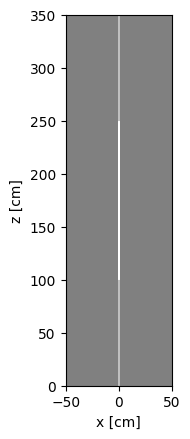

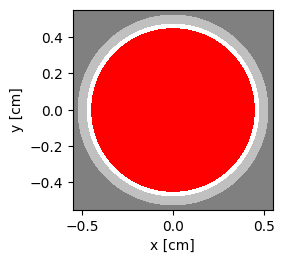

In [3]:
# GEOMETRY Definitions

# I have to build single fuel pins that than we insert in an hexagonal lattice to model each single FA!!!
# Dimensions of interest:
r1 = 0.9/2   #cm fuel pellet radius
r2 = 0.95/2  #cm inner cladding Gap_t=250mu
r3 = 1.05/2 #cm outer cladding Clad_t=0.5cm
h_endcap = 100 #cm
h_freeV = 60 #cm
h_active = 90 #cm
h_total = 350 #cm

# Planes
fuel_cylinder = openmc.ZCylinder(r=r1)
clad_inner_cyl = openmc.ZCylinder(r=r2)
clad_outer_cyl = openmc.ZCylinder(r=r3)

up_limit = openmc.ZPlane(z0=+h_total, boundary_type="reflective")
low_limit = openmc.ZPlane(z0=0, boundary_type="reflective")
fuel_uplimit = openmc.ZPlane(z0=+h_endcap+h_active, boundary_type="vacuum")
fuel_lowlimit = openmc.ZPlane(z0=+h_endcap, boundary_type="vacuum")
free_volume_uplimit = openmc.ZPlane(z0=+h_endcap+h_active+h_freeV, boundary_type="vacuum")

# Regions
fuel_region1 = -fuel_cylinder & -fuel_uplimit & +fuel_lowlimit
fuel_region2 = -fuel_cylinder & -fuel_uplimit & +fuel_lowlimit
fuel_region3 = -fuel_cylinder & -fuel_uplimit & +fuel_lowlimit
steel_region = (-clad_outer_cyl & +clad_inner_cyl & -up_limit & +low_limit) | (-up_limit & +free_volume_uplimit & -clad_outer_cyl) | (-fuel_lowlimit & +low_limit & -clad_outer_cyl)
filling_region = (-clad_inner_cyl & +fuel_cylinder & +fuel_lowlimit & -fuel_uplimit) | (+fuel_uplimit & -free_volume_uplimit & -clad_inner_cyl)
coolant_region = +clad_outer_cyl & -up_limit & +low_limit

# Cells!!!
# Since we have to define 3 Universes we have also to define multiple times the same kind of cell (lead, steel, gas)
# This is because OpenMC can make confusion in assigning the same cell to different universes!!!

fuel_1_cell = openmc.Cell(fill=fuel_1, region=fuel_region1) 
fuel_2_cell = openmc.Cell(fill=fuel_2, region=fuel_region2)
fuel_3_cell = openmc.Cell(fill=fuel_3, region=fuel_region3)

steel_cell1 = openmc.Cell(fill=T91_SS, region=steel_region)
steel_cell2= openmc.Cell(fill=T91_SS, region=steel_region)
steel_cell3 = openmc.Cell(fill=T91_SS, region=steel_region)

lead_cell1 = openmc.Cell(fill=coolant, region=coolant_region)
lead_cell2 = openmc.Cell(fill=coolant, region=coolant_region)
lead_cell3 = openmc.Cell(fill=coolant, region=coolant_region)

gas_cell1 = openmc.Cell(fill=helium, region=filling_region)
gas_cell2 = openmc.Cell(fill=helium, region=filling_region)
gas_cell3 = openmc.Cell(fill=helium, region=filling_region)

empty_cell = openmc.Cell(fill=coolant) # define a coolant cell for the only coolant universe

# Single Fuel Pins Universes: these universes will be used to fill the Fuel assemblies!!!
Fuel_Pin_Z1 = openmc.Universe(cells=[fuel_1_cell, steel_cell1, lead_cell1, gas_cell1])
Fuel_Pin_Z2 = openmc.Universe(cells=[fuel_2_cell, steel_cell2, lead_cell2, gas_cell2])
Fuel_Pin_Z3 = openmc.Universe(cells=[fuel_3_cell, steel_cell3, lead_cell3, gas_cell3])
empty_universe = openmc.Universe(cells=[empty_cell]) # it is used as universe outside the Assembly (next part of Geometry def)

# PLOTTING the single fuel rod to check geometry
# we can print Universes using .plot directly on it---> we cannot export geometry now because u have to do it when the whole system is complete!!!

# Plotting Fuel Pin Vertically
Fuel_Pin_Z1.plot(origin=(0,0,h_total/2),
                 basis='xz',
                 width=(100, h_total),
                 color_by='material',
                 colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'})

# Plotting Fuel Pin Section
Fuel_Pin_Z1.plot(origin=(0,0,h_total/2),
                 basis='xy',
                 width=(1.1, 1.1),
                 color_by='material',
                 colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'})

## Geometry - Fuel Assemblies

I build here the FA for the Zone 1.

I have to repeat the same operation for Zones 2 and 3. This Operation must be done separately because there is the possbility that openmc makes confusion in the assignement process ---> confusion in assigning materials to the right cell

/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

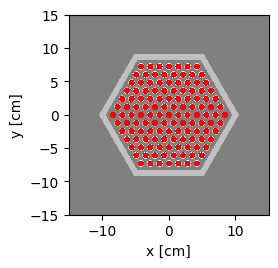

In [4]:
# GEOMETRY Definition of Fuel Assemblies with Hexagonal Shape
# each single FA is characterized by 127 fuel pins organized in 7 rings with (1, 6, 12, 18, 24, 30, 36) pins

pitch = 1.4 #cm
edge_wrapper = 9.5 #cm
wrapper_t = 0.5 #cm


# 1) Zone 1 Fuel Assemblies
FA_zone1 = openmc.HexLattice(name="Hexagonal Lattice Zone 1")
FA_zone1.center = (0,0)
FA_zone1.pitch = (pitch,)
FA_zone1.orientation = 'x'
FA_zone1.outer = empty_universe # outside the Assembly we have coolant (universe filled with Coolant)

# We have to define each ring repeating the number of Fuel Rods (fuel of interest) for each ring
number_elementsXring = [36, 30, 24, 18, 12, 6, 1]
ring11 = [Fuel_Pin_Z1]*number_elementsXring[0]
ring12 = [Fuel_Pin_Z1]*number_elementsXring[1]
ring13 = [Fuel_Pin_Z1]*number_elementsXring[2]
ring14 = [Fuel_Pin_Z1]*number_elementsXring[3]
ring15 = [Fuel_Pin_Z1]*number_elementsXring[4]
ring16 = [Fuel_Pin_Z1]*number_elementsXring[5]
ring17 = [Fuel_Pin_Z1]*number_elementsXring[6]
# The FA lattice is composed by the above defined universes:
FA_zone1.universes = [ring11, ring12, ring13, ring14, ring15, ring16, ring17]

# We have now to create the Wrapper geometry and fill inside with the FA_zone1 and outside with coolant only
wrapper_inner1 = openmc.model.hexagonal_prism(edge_length=edge_wrapper, orientation='x', boundary_type='vacuum')
wrapper_outer1 = openmc.model.hexagonal_prism(edge_length=edge_wrapper+wrapper_t*2, orientation='x', boundary_type='vacuum')
#outer_boundary = openmc.model.rectangular_prism(width=30, height=30, origin=(0,0), boundary_type='reflective')

# Inside the wrapper we have fuel rods, whereas outside we have coolant
fuel_assembly_1_cell = openmc.Cell(fill=FA_zone1, region = wrapper_inner1 & -up_limit & +low_limit)
coolant_assembly_1_cell = openmc.Cell(fill=coolant, region = ~wrapper_outer1 & -up_limit & +low_limit)
wrapper_cell = openmc.Cell(fill=T91_SS, region = wrapper_outer1 & ~wrapper_inner1 & -up_limit & +low_limit)

# FA for Zone 1 Universe definition
FA_1 = openmc.Universe(cells = [fuel_assembly_1_cell, coolant_assembly_1_cell, wrapper_cell])

FA_1.plot(
    origin = (0,0,h_total/2),
    pixels =(200, 200),
    width = (30.,30.),
    color_by = 'material', 
    colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'})

/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

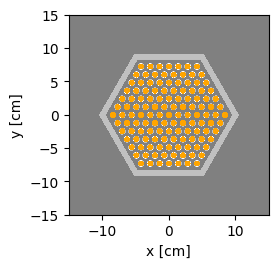

In [5]:
# 2) Zone 2 Fuel Assemblies
FA_zone2 = openmc.HexLattice(name="Hexagonal Lattice Zone 2")
FA_zone2.center = (0,0)
FA_zone2.pitch = (pitch,)
FA_zone2.orientation = 'x'
FA_zone2.outer = empty_universe # outside the Assembly we have coolant (universe filled with Coolant)

# We have to define each ring repeating the number of Fuel Rods (fuel of interest) for each ring
ring21 = [Fuel_Pin_Z2]*number_elementsXring[0]
ring22 = [Fuel_Pin_Z2]*number_elementsXring[1]
ring23 = [Fuel_Pin_Z2]*number_elementsXring[2]
ring24 = [Fuel_Pin_Z2]*number_elementsXring[3]
ring25 = [Fuel_Pin_Z2]*number_elementsXring[4]
ring26 = [Fuel_Pin_Z2]*number_elementsXring[5]
ring27 = [Fuel_Pin_Z2]*number_elementsXring[6]

# The FA lattices for Zone 2 and 3:
FA_zone2.universes = [ring21, ring22, ring23, ring24, ring25, ring26, ring27]

wrapper_inner2 = openmc.model.hexagonal_prism(edge_length=edge_wrapper, orientation='x', boundary_type='vacuum')
wrapper_outer2 = openmc.model.hexagonal_prism(edge_length=edge_wrapper+wrapper_t*2, orientation='x', boundary_type='vacuum')

# Fuel and Coolant Cells for Zone 2 and 3
fuel_assembly_2_cell = openmc.Cell(fill=FA_zone2, region = wrapper_inner2 & -up_limit & +low_limit)
coolant_assembly_2_cell = openmc.Cell(fill=coolant, region = ~wrapper_outer2 & -up_limit & +low_limit)
wrapper_cell2 = openmc.Cell(fill=T91_SS, region = wrapper_outer2 & ~wrapper_inner2 & -up_limit & +low_limit)

# FA for Zone 2 and 3 Universe definition
FA_2 = openmc.Universe(cells = [fuel_assembly_2_cell, coolant_assembly_2_cell, wrapper_cell2])

# Plotting FA Zone 2
FA_2.plot(
    origin = (0,0,h_total/2),
    pixels =(200, 200),
    width = (30.,30.),
    color_by = 'material', 
    colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'})

/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

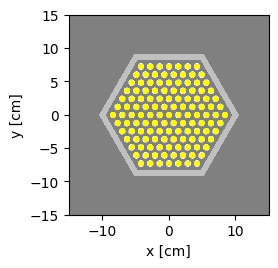

In [6]:
# 3) Zone 3 Fuel Assemblies
FA_zone3 = openmc.HexLattice(name="Hexagonal Lattice Zone 3")
FA_zone3.center = (0,0)
FA_zone3.pitch = (pitch,)
FA_zone3.orientation = 'x'
FA_zone3.outer = empty_universe # outside the Assembly we have coolant (universe filled with Coolant)

ring31 = [Fuel_Pin_Z3]*number_elementsXring[0]
ring32 = [Fuel_Pin_Z3]*number_elementsXring[1]
ring33 = [Fuel_Pin_Z3]*number_elementsXring[2]
ring34 = [Fuel_Pin_Z3]*number_elementsXring[3]
ring35 = [Fuel_Pin_Z3]*number_elementsXring[4]
ring36 = [Fuel_Pin_Z3]*number_elementsXring[5]
ring37 = [Fuel_Pin_Z3]*number_elementsXring[6]

# The FA lattices for Zone 2 and 3:
FA_zone3.universes = [ring31, ring32, ring33, ring34, ring35, ring36, ring37]

wrapper_inner3 = openmc.model.hexagonal_prism(edge_length=edge_wrapper, orientation='x', boundary_type='vacuum')
wrapper_outer3 = openmc.model.hexagonal_prism(edge_length=edge_wrapper+wrapper_t*2, orientation='x', boundary_type='vacuum')

# Fuel and Coolant Cells for Zone 2 and 3
fuel_assembly_3_cell = openmc.Cell(fill=FA_zone3, region = wrapper_inner3 & -up_limit & +low_limit)
coolant_assembly_3_cell = openmc.Cell(fill=coolant, region = ~wrapper_outer3 & -up_limit & +low_limit)
wrapper_cell3 = openmc.Cell(fill=T91_SS, region = wrapper_outer3 & ~wrapper_inner3 & -up_limit & +low_limit)

# FA for Zone 2 and 3 Universe definition
FA_3 = openmc.Universe(cells = [fuel_assembly_3_cell, coolant_assembly_3_cell, wrapper_cell3])

# Plotting FA Zone 3
FA_3.plot(
    origin = (0,0,h_total/2),
    pixels =(200, 200),
    width = (30.,30.),
    color_by = 'material', 
    colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'})

## Geometry - Core Geometry Definition

/usr/local/lib/python3.9/dist-packages/openmc/model/funcs.py:124: FutureWarning: The hexagonal_prism(...) function has been replaced by the HexagonalPrism(...) class. Future versions of OpenMC will not accept hexagonal_prism.
  warn("The hexagonal_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

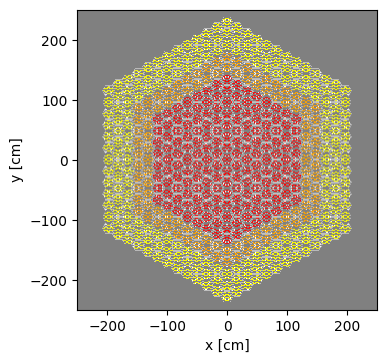

In [7]:
# We can use now the same strategy to build the hexagonal structure of the core

FA_pitch = 19 #cm space between assemblies
reactor_lattice_side = 650 #cm (diamter = 13m => radius=6.5m)

core_lattice = openmc.HexLattice(name="Hexagonal Core Structure")
core_lattice.center = (0,0)
core_lattice.pitch = (FA_pitch,)
core_lattice.orientation = 'y'
core_lattice.outer = empty_universe

# The first 7 rings are filled with FA with Fuel1, whereas the other zones are filled with Fuel2 and Fuel3!!!
number_assemblyXring = [72, 66, 60, 54, 48, 42, 36, 30, 24, 18, 12, 6, 1]
ring12 = [FA_3]*number_assemblyXring[0]
ring11= [FA_3]*number_assemblyXring[1]
ring10 = [FA_3]*number_assemblyXring[2]
ring9 = [FA_2]*number_assemblyXring[3]
ring8 = [FA_2]*number_assemblyXring[4]
ring7 = [FA_1]*number_assemblyXring[5]
ring6 = [FA_1]*number_assemblyXring[6]
ring5 = [FA_1]*number_assemblyXring[7]
ring4 = [FA_1]*number_assemblyXring[8]
ring3 = [FA_1]*number_assemblyXring[9]
ring2 = [FA_1]*number_assemblyXring[10]
ring1 = [FA_1]*number_assemblyXring[11]
ring0 = [FA_1]*number_assemblyXring[12]

# The core lattice universes
core_lattice.universes = [ring12, ring11, ring10, ring9, ring8, ring7, ring6, ring5, ring4, ring3, ring2, ring1, ring0]

# Separation layer
separation_layer = openmc.model.hexagonal_prism(edge_length=reactor_lattice_side, orientation='y', boundary_type='vacuum')

# Core Cells
core_cell = openmc.Cell(fill=core_lattice, region = separation_layer & -up_limit & +low_limit)
coolant_core_cell = openmc.Cell(fill=coolant, region = ~separation_layer & -up_limit & +low_limit)

# Core Universe
core_universe = openmc.Universe(cells=[core_cell, coolant_core_cell])


core_universe.plot(origin = (0,0,h_total/2),
                   pixels =(300, 300),
                   width = (500,500),
                   color_by = 'material',
                   colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'})

## Geometry - Core Barrel

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

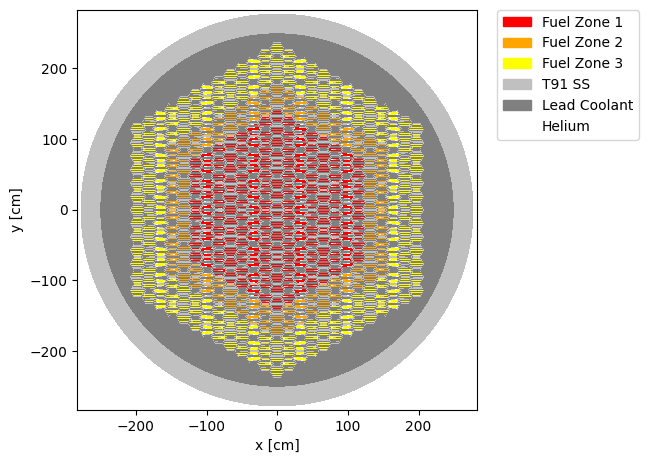

In [8]:
# The core barrel is a cylindrical SS barrel able to contain the reactor core
r_barrel = 250 #cm diameter 5m
r_barrel_out = r_barrel + 28 #cm 

barrel_plane_in = openmc.ZCylinder(r=r_barrel)
barrel_plane_out = openmc.ZCylinder(r=r_barrel_out)

vessel_cell = openmc.Cell(fill=core_universe, region=-barrel_plane_in & -up_limit & +low_limit)
barrel_cell = openmc.Cell(fill=T91_SS, region=+barrel_plane_in & -barrel_plane_out & -up_limit & +low_limit)

ReactorPressuerVessel = openmc.Universe(cells=[vessel_cell, barrel_cell])

#Plotting Reactor Pressure Vessel!!!
ReactorPressuerVessel.plot(origin = (0,0,h_total/2),
                           pixels =(400, 400),
                           width = (2*r_barrel_out+10, 2*r_barrel_out+10),
                           legend = True,
                           color_by = 'material',
                           colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'})

In [9]:
# EXPORTING geometry
# It allowa also to plot better images selecting colors for each material!!!
geometry = openmc.Geometry(ReactorPressuerVessel)
geometry.export_to_xml()

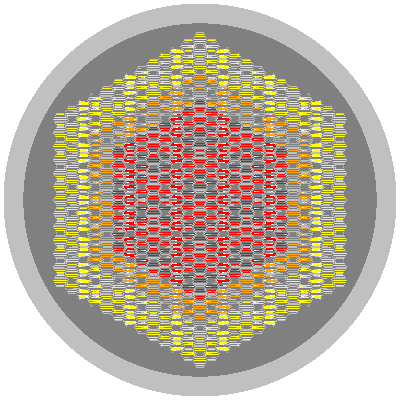

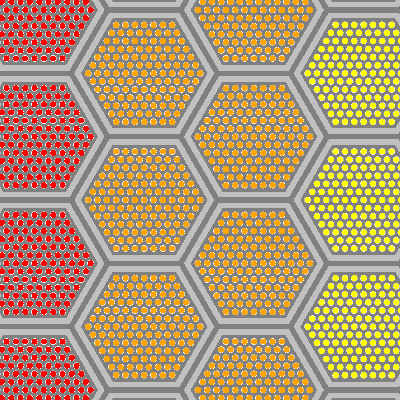

In [10]:
# Plotting the entire core!!!
plot1 = openmc.Plot.from_geometry(geometry)
plot1.basis = 'xy'
plot1.origin = (0,0,h_total/2)
plot1.width = (2*r_barrel_out+10, 2*r_barrel_out+10)
plot1.color_by = 'material'
plot1.colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'}

# Zoom to see the different Fuel compositions
plot2 = openmc.Plot.from_geometry(geometry)
plot2.basis = 'xy'
plot2.origin = (140,0,h_total/2)
plot2.width = (60, 60)
plot2.color_by = 'material'
plot2.colors = {fuel_1:'red', fuel_2:'orange', fuel_3:'yellow', T91_SS:'silver', coolant:'grey', helium:'white'}

plots = openmc.Plots([plot1, plot2])
openmc.plot_inline(plots)

## Source and Settings Definition

In [11]:
# SOURCE Definition

source_space = openmc.stats.Box([-r_barrel_out, -r_barrel_out, 0], [r_barrel_out, r_barrel_out, (h_endcap+h_active)], only_fissionable=True)
source = openmc.Source(space=source_space)
source.angle = openmc.stats.Isotropic()

# SETTINGS Definition
settings = openmc.Settings()
settings.source = source
settings.batches = 20
settings.inactve = 5
settings.particles = 20000

settings.export_to_xml()


/usr/local/lib/python3.9/dist-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


## Tallies and Filters

In [12]:
# Spatial Filters:
# I create a spatial mesh that is used to define a Spatial Filter
# The Spatial Filter is then given in input to the Openmc.Tally---> we calculate the scores using the spatial mesh

mesh_sp = openmc.RegularMesh()
mesh_sp.dimension = [2*r_barrel_out, 2*r_barrel_out, 1]
mesh_sp.lower_left = [-r_barrel_out, -r_barrel_out, (h_endcap + h_active/2 - 1)]
mesh_sp.upper_right = [r_barrel_out, r_barrel_out, (h_endcap + h_active/2 + 1)]
# Filter Spatial
mesh_filter = openmc.MeshFilter(mesh_sp)

# Tally definition
tally_1 = openmc.Tally(name='Simulation 1')
tally_1.filters = [mesh_filter]
tally_1.scores = ['flux', 'fission']

tallies = openmc.Tallies([tally_1])
tallies.export_to_xml()

## Running Simulation

In [13]:
# Running simulation
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## StatePoint File and Output Analysis

In [14]:
#SatePoint Extraction Process

sp = openmc.StatePoint('statepoint.20.h5')

tally_get = sp.get_tally(name='Simulation 1')
get_flux = tally_get.get_slice(scores=['flux'])
get_fissions = tally_get.get_slice(scores=['fission'])
                     
get_flux.mean.shape=(2*r_barrel_out, 2*r_barrel_out)
get_fissions.mean.shape=(2*r_barrel_out, 2*r_barrel_out)

Text(0, 0.5, 'Y (cm)')

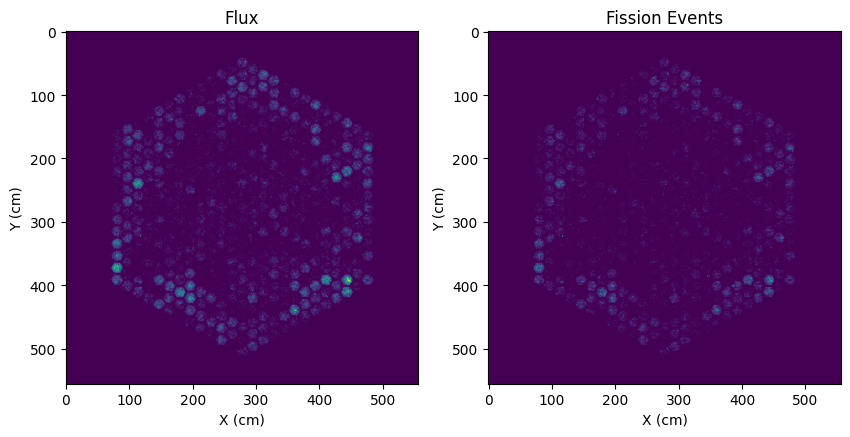

In [15]:
# Plotting Final Results of Flux and Fission Events distributed as descibed by the Filter Mesh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(get_flux.mean)
ax1.set_title("Flux", fontsize=12)
ax1.set_xlabel("X (cm)")
ax1.set_ylabel("Y (cm)")

ax2.imshow(get_fissions.mean)
ax2.set_title("Fission Events", fontsize=12)
ax2.set_xlabel("X (cm)")
ax2.set_ylabel("Y (cm)")